In [1]:
# Import libraries 
import os 
import numpy as np 
import pandas as pd 
import re 
import matplotlib.pyplot as plt 
import cv2
import tensorflow as tf

2024-03-19 12:55:12.076415: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 12:55:12.076650: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 12:55:12.284836: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Defining data form of set
data_train = {'img' : [],'mask' : []}
data_test = {'img' : [],'mask' : []}

# Data loader function
def LoadData( data_set = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath) # Get image names
    maskNames = [] # Get mask names   
    for i in imgNames:
        maskNames.append(re.sub('\.png', '_L.png', i)) # L: lablel
    # Get address 
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    # Divide data
    for i in range (len(imgNames)):
        # Read data
        img = plt.imread(imgAddr + imgNames[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        # Resize the image as 512x512
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        # Divide data
        data_set['img'].append(img)
        data_set['mask'].append(mask)
        
    return data_set

In [3]:
data_train = LoadData( data_train, imgPath = '/kaggle/input/camvid/CamVid/train', maskPath = '/kaggle/input/camvid/CamVid/train_labels', shape = 256)

In [4]:
data_test  = LoadData( data_test, imgPath = '/kaggle/input/camvid/CamVid/test', maskPath = '/kaggle/input/camvid/CamVid/test_labels', shape = 256)

In [5]:
# Display function: include 2 subplots: image and mask
def DisplayData(data_set = None,index=1):
    plt.subplot(1,2,1)
    plt.imshow(data_set['img'][index])
    plt.title("Image")
    plt.subplot(1,2,2)
    plt.imshow(data_set['mask'][index])
    plt.title("Mask")
    plt.show()

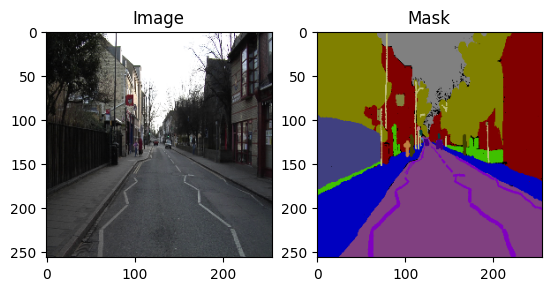

In [6]:
DisplayData(data_train,3)

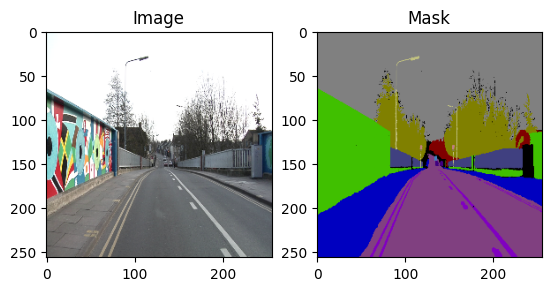

In [7]:
DisplayData(data_test,2)

In [8]:
# Convert data set to array
data_train_img = np.array(data_train['img'])
data_train_mask = np.array(data_train['mask'])

data_test_img = np.array(data_test['img'])
data_test_mask = np.array(data_test['mask'])

data_train = {'img': data_train_img ,'mask' : data_train_mask}
data_test = {'img': data_test_img ,'mask' : data_test_mask}

In [9]:
# Double Convolution 
def DoubleConv(input_tensor, nb_filters, ker_size = 3):
    # 1st Convolution 
    conv = tf.keras.layers.Conv2D(filters=nb_filters, kernel_size = (ker_size,ker_size), kernel_initializer = 'he_normal', padding = 'same') (input_tensor)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation('relu')(conv)
    
    # 2nd Conv
    conv = tf.keras.layers.Conv2D(filters=nb_filters, kernel_size = (ker_size,ker_size), kernel_initializer = 'he_normal', padding = 'same') (conv)
    conv = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Activation('relu')(conv)
    
    return conv

# U-net: there are 2 paths: encoder and decoder ( or contracting path and expansive path)
def UNET (input_image,nb_filters=16,drop_out=0.1):
    # Encoder path (or contracting path)
    '''The contracting path follows the typical architecture of a convolutional network. 
    It consists of the repeated application of two 3x3 convolutions, each followed by a ReLU 
    and a 2x2 max pooling operation with stride 2 for downsampling. At each downsampling 
    step we double the number of feature channels.'''
    
    conv1 = DoubleConv(input_image,nb_filters,ker_size=3)
    max_pool1 = tf.keras.layers.MaxPooling2D((2,2))(conv1)
    max_pool1 = tf.keras.layers.Dropout(drop_out)(max_pool1)
    
    conv2 = DoubleConv(max_pool1,nb_filters*2,ker_size=3)
    max_pool2 = tf.keras.layers.MaxPooling2D((2,2))(conv2)
    max_pool2 = tf.keras.layers.Dropout(drop_out)(max_pool2)
    
    conv3 = DoubleConv(max_pool2,nb_filters*4,ker_size=3)
    max_pool3 = tf.keras.layers.MaxPooling2D((2,2))(conv3)
    max_pool3 = tf.keras.layers.Dropout(drop_out)(max_pool3)
    
    conv4 = DoubleConv(max_pool3,nb_filters*8,ker_size=3)
    max_pool4 = tf.keras.layers.MaxPooling2D((2,2))(conv4)
    max_pool4 = tf.keras.layers.Dropout(drop_out)(max_pool4)
    
    conv5 = DoubleConv(max_pool4,nb_filters*16,ker_size = 3)
    
    # Decoder path (or expansive path)
    '''. Every step in the expansive path consists of an upsampling of the feature map followed
    by a 2x2 convolution that halves the number of feature channels, a concatenation 
    with the correspondingly cropped feature map from the contracting path, and two 3x3 convolutions, 
    each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. 
    At the final layer a 1x1 convolution is used to map each 64-component feature vector to the desired 
    number of classes. In total the network has 23 convolutional layers.'''
    
    upConv1 = tf.keras.layers.Conv2DTranspose(nb_filters*8, kernel_size= (3,3),strides= (2,2), padding='same')(conv5)
    upConv1 = tf.keras.layers.concatenate([upConv1,conv4])
    upConv1 = tf.keras.layers.Dropout(drop_out)(upConv1)
    conv6 = DoubleConv(upConv1,nb_filters*8,ker_size=3)
    
    upConv2 = tf.keras.layers.Conv2DTranspose(nb_filters*4, kernel_size= (3,3),strides= (2,2), padding='same')(conv6)
    upConv2 = tf.keras.layers.concatenate([upConv2,conv3])
    upConv2 = tf.keras.layers.Dropout(drop_out)(upConv2)
    conv7 = DoubleConv(upConv2,nb_filters*4,ker_size=3)
    
    upConv3 = tf.keras.layers.Conv2DTranspose(nb_filters*2, kernel_size= (3,3) ,strides= (2,2), padding='same')(conv7)
    upConv3 = tf.keras.layers.concatenate([upConv3,conv2])
    upConv3 = tf.keras.layers.Dropout(drop_out)(upConv3)
    conv8 = DoubleConv(upConv3,nb_filters*2,ker_size=3)
    
    upConv4 = tf.keras.layers.Conv2DTranspose(nb_filters, kernel_size= (3,3),strides= (2,2), padding='same')(conv8)
    upConv4 = tf.keras.layers.concatenate([upConv4,conv1])
    upConv4 = tf.keras.layers.Dropout(drop_out)(upConv4)
    conv9 = DoubleConv(upConv4,nb_filters*1,ker_size=3)
    
    out_put = tf.keras.layers.Conv2D(3,(1,1),activation='sigmoid')(conv9)
    model = tf.keras.Model(inputs = [input_image], outputs =[out_put])
    
    return model

In [10]:
# Initial Model
input_image = tf.keras.layers.Input((256,256,3))
myModel = UNET(input_image,drop_out=0.08)
myModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [11]:
# Training Model
trainModel = myModel.fit(data_train['img'], data_train['mask'], epochs = 50, verbose = 1) # About 1 hour for 50 epochs

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 203s 15s/step - accuracy: 0.2270 - loss: 0.7210
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 202s 15s/step - accuracy: 0.3859 - loss: 0.6351
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 202s 15s/step - accuracy: 0.4918 - loss: 0.6034
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 184s 15s/step - accuracy: 0.5152 - loss: 0.5836
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 184s 15s/step - accuracy: 0.5293 - loss: 0.5684
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 182s 15s/step - accuracy: 0.5232 - loss: 0.5628
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 202s 15s/step - accuracy: 0.5185 - loss: 0.5606
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 186s 15s/step - accuracy: 0.5300 - loss: 0.5496
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 201s 15s/step - accuracy: 0.5281 - loss: 0.5449
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 204s 16s/step - accuracy: 0.5393 - loss: 0.5427
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 198s 15s/step - accuracy: 0.5283 - loss: 0.5381
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 204s 15s/step

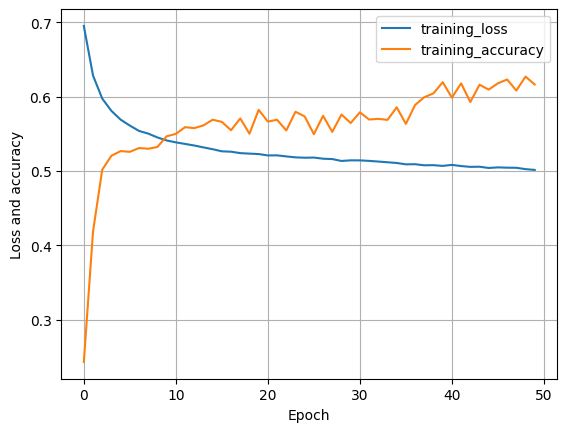

In [12]:
plt.xlabel('Epoch')
plt.ylabel('Loss and accuracy')
plt.plot(trainModel.history['loss'], label = 'training_loss')
plt.plot(trainModel.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [13]:
# Prediction 
def predict (data_test, model, shape = 256):
    ## getting and proccessing test dataset
    image = data_test['img']
    mask = data_test['mask']
    
    predictions = model.predict(image)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, image , mask

# Display predicted results
def show_predictions (image, prediction , mask):
    plt.figure(figsize=(10,10))
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.title('Image')
    
    plt.subplot(1,3,2)
    plt.imshow(prediction)
    plt.title('Predicted Mask')
    
    plt.subplot(1,3,3)
    plt.imshow(mask)
    plt.title('Actual Mask')

8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step


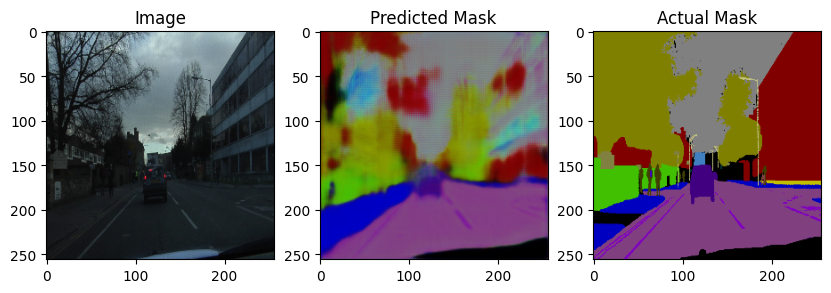

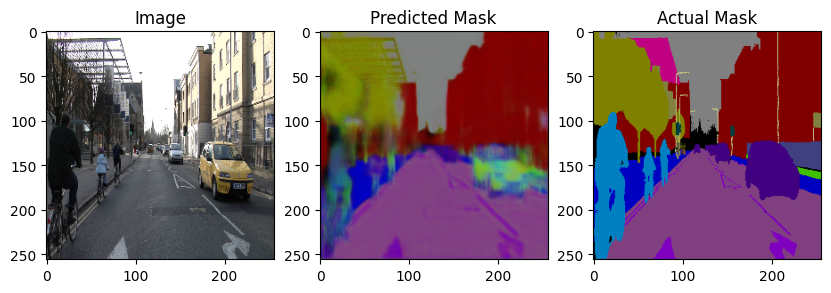

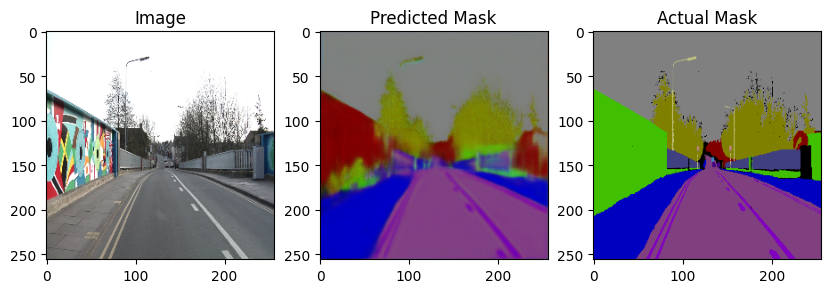

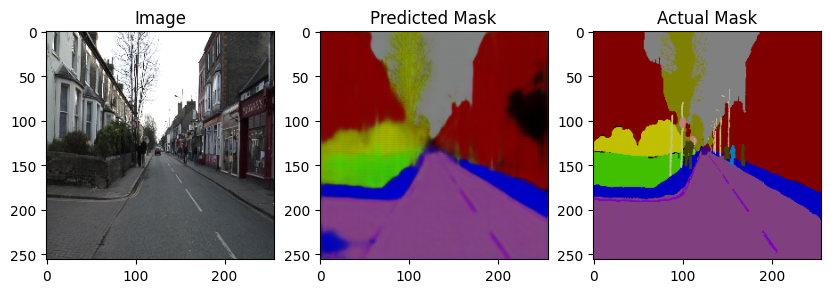

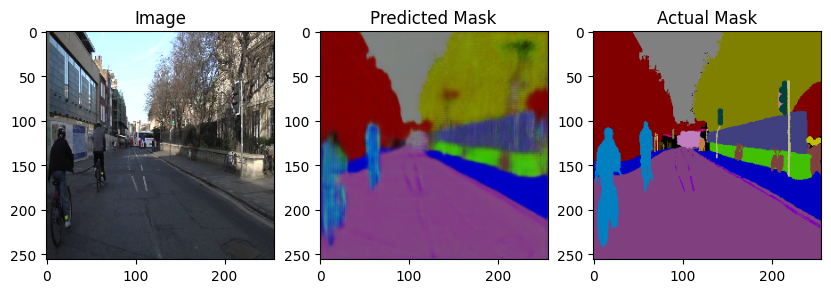

In [14]:
# Get predict results
predictions, image, mask = predict(data_test,myModel)

# Show some examples 
for i in range(5):
    show_predictions(image[i],predictions[i],mask[i])

We can see that this model can predict some objects in the image after 50 epochs of training, but they are still not clear. Therefore, to address this issue, we need to train the model for more epochs, for example, 300 or 500.

In [15]:
# Initial Model
input_image = tf.keras.layers.Input((256,256,3))
myNewModel = UNET(input_image,drop_out=0.08)
myNewModel.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [16]:
# Training Model
trainNewModel = myNewModel.fit(data_train['img'], data_train['mask'], epochs = 100, verbose = 1) 

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 211s 16s/step - accuracy: 0.1150 - loss: 0.7546
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 234s 19s/step - accuracy: 0.2976 - loss: 0.6548
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 194s 16s/step - accuracy: 0.5264 - loss: 0.6315
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 193s 16s/step - accuracy: 0.4660 - loss: 0.6150
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 235s 19s/step - accuracy: 0.4967 - loss: 0.6014
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 193s 16s/step - accuracy: 0.5119 - loss: 0.5902
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 215s 17s/step - accuracy: 0.5061 - loss: 0.5840
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 273s 18s/step - accuracy: 0.5081 - loss: 0.5775
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 193s 16s/step - accuracy: 0.5026 - loss: 0.5720
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 196s 16s/step - accuracy: 0.5045 - loss: 0.5690
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 210s 18s/step - accuracy: 0.5278 - loss: 0.5630
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1